In [1]:
!pip install --upgrade diffusers transformers accelerate safetensors pillow
!pip install clean-fid

In [2]:
from huggingface_hub import notebook_login
notebook_login()  # paste your token from huggingface.co/settings/tokens

In [3]:
from google.colab import drive
drive.mount("/content/drive")

path_photo = "/content/drive/MyDrive/photos"         # your photos
out_dir    = "/content/drive/MyDrive/project_outputs/diffusion"  # where to save results

Mounted at /content/drive


In [4]:
import os
os.makedirs(out_dir, exist_ok=True)

In [5]:
import torch
from diffusers import StableDiffusionImg2ImgPipeline

model_id = "avuhong/DB_Monet_style"

pipe = StableDiffusionImg2ImgPipeline.from_pretrained(
    model_id,
    torch_dtype=torch.float16
).to("cuda")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/512 [00:00<?, ?B/s]

Fetching 12 files:   0%|          | 0/12 [00:00<?, ?it/s]

text_encoder/pytorch_model.bin:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/341 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/993 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/925 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/618 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

unet/diffusion_pytorch_model.bin:   0%|          | 0.00/3.46G [00:00<?, ?B/s]

vae/diffusion_pytorch_model.bin:   0%|          | 0.00/335M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/713 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--avuhong--DB_Monet_style/snapshots/25f3d4e3273183b65d7e3c51c4d00eb7e0f9538a/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--avuhong--DB_Monet_style/snapshots/25f3d4e3273183b65d7e3c51c4d00eb7e0f9538a/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--avuhong--DB_Monet_style/snapshots/25f3d4e3273183b65d7e3c51c4d00eb7e0f9538a/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--avuhong--DB_Monet_style/snapshots/25f3d4e3273183b65d7e3c51c4d00eb7e0f9538a/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
`torch_dtype` is deprecated! Use `dtype` instead!


  0%|          | 0/24 [00:00<?, ?it/s]

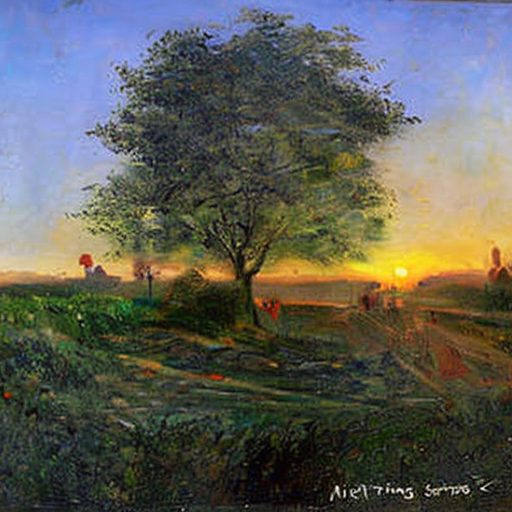

In [6]:
from PIL import Image

def monetize_one(photo_path, out_path,
                 strength=0.6,
                 guidance_scale=7.5,
                 steps=40):
    """
    photo_path: path to your input photo
    out_path: where to save the Monet-style result
    strength: 0-1, higher -> more Monet style, lower -> more content preserved
    """
    init_image = Image.open(photo_path).convert("RGB")
    # SD1.5 works best around 512x512; this keeps aspect ratio but you can also force 512x512
    init_image = init_image.resize((512, 512), Image.LANCZOS)

    # Prompt uses the instance key mentioned in the model card: "a painting in $M## style of ..."
    prompt = "a painting in $M## style of the same scene"

    with torch.autocast("cuda"):
        result = pipe(
            prompt=prompt,
            image=init_image,
            strength=strength,
            guidance_scale=guidance_scale,
            num_inference_steps=steps,
        )
    img = result.images[0]
    img.save(out_path)
    return img

# Example on one image
test_photo = os.path.join(path_photo, os.listdir(path_photo)[0])
out_path   = os.path.join(out_dir, "monet_example.png")
img = monetize_one(test_photo, out_path)
img

In [7]:
from tqdm import tqdm

photo_files = [
    f for f in os.listdir(path_photo)
    if f.lower().endswith((".jpg", ".jpeg", ".png"))
]

# Take only the first 10
photo_files = photo_files[:10]

for fname in tqdm(photo_files):
    in_path  = os.path.join(path_photo, fname)
    out_path = os.path.join(out_dir, f"monet_{fname}")
    monetize_one(in_path, out_path,
                 strength=0.6,
                 guidance_scale=7.5,
                 steps=40)


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:03<00:34,  3.84s/it]

  0%|          | 0/24 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:08<00:34,  4.31s/it]

  0%|          | 0/24 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:13<00:31,  4.45s/it]

  0%|          | 0/24 [00:00<?, ?it/s]

 40%|████      | 4/10 [00:17<00:26,  4.42s/it]

  0%|          | 0/24 [00:00<?, ?it/s]

 50%|█████     | 5/10 [00:24<00:26,  5.40s/it]

  0%|          | 0/24 [00:00<?, ?it/s]

 60%|██████    | 6/10 [00:30<00:21,  5.49s/it]

  0%|          | 0/24 [00:00<?, ?it/s]

 70%|███████   | 7/10 [00:34<00:15,  5.24s/it]

  0%|          | 0/24 [00:00<?, ?it/s]

 80%|████████  | 8/10 [00:39<00:10,  5.08s/it]

  0%|          | 0/24 [00:00<?, ?it/s]

 90%|█████████ | 9/10 [00:44<00:04,  4.96s/it]

  0%|          | 0/24 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:48<00:00,  4.90s/it]


In [9]:
import os
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt

photo_files = [
    f for f in os.listdir(path_photo)
    if f.lower().endswith((".jpg", ".jpeg", ".png"))
]

# Take only the first 5
photo_files = photo_files[:5]

for fname in tqdm(photo_files):
    in_path  = os.path.join(path_photo, fname)
    out_path = os.path.join(out_dir, f"monet_{fname}")

    # Generate Monet style
    monet_img = monetize_one(in_path, out_path,
                             strength=0.6,
                             guidance_scale=7.5,
                             steps=40)

    # Load original image (resize for display consistency)
    orig = Image.open(in_path).convert("RGB")
    orig = orig.resize((512, 512), Image.LANCZOS)

    # Side-by-side plot
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    axes[0].imshow(orig)
    axes[0].set_title("Original Photo")
    axes[0].axis("off")

    axes[1].imshow(monet_img)
    axes[1].set_title("Monet Style Output")
    axes[1].axis("off")

    plt.tight_layout()

    # Save combined visualization
    combined_path = os.path.join(out_dir, f"comparison_{fname}.png")
    plt.savefig(combined_path, dpi=150)
    plt.close()


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:05<00:22,  5.66s/it]

  0%|          | 0/24 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:10<00:15,  5.21s/it]

  0%|          | 0/24 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:15<00:10,  5.22s/it]

  0%|          | 0/24 [00:00<?, ?it/s]

 80%|████████  | 4/5 [00:20<00:05,  5.21s/it]

  0%|          | 0/24 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:26<00:00,  5.25s/it]


In [8]:
from cleanfid import fid

real_dir = "/content/drive/MyDrive/monet_paintings"
gen_dir  = "/content/drive/MyDrive/project_outputs/diffusion"

score = fid.compute_fid(real_dir, gen_dir)
print("FID =", score)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


compute FID between two folders
Found 300 images in the folder /content/drive/MyDrive/monet_paintings


FID monet_paintings : 100%|██████████| 10/10 [00:28<00:00,  2.83s/it]


Found 11 images in the folder /content/drive/MyDrive/project_outputs/diffusion


FID diffusion : 100%|██████████| 1/1 [00:05<00:00,  5.41s/it]


FID = 245.68762432317627
